In [194]:
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from fastai import *
from fastai.vision import *

In [2]:
ds_root = Path('./dataset/rtsd-r3')

In [3]:
size = (64, 64)
bs = 512


train_df = pd.read_csv(ds_root / 'gt_train.csv', index_col='filename')
val_df = pd.read_csv(ds_root / 'gt_test.csv', index_col='filename')


def get_label(p):
    folder_name = p.parent.name
    img_name = p.name
    
    df = train_df if folder_name == 'train' else val_df
    return df.loc[img_name][0]


data = (ImageList.from_folder(ds_root)
        .split_by_folder(train='train', valid='test')
        .label_from_func(get_label)
        .transform(get_transforms(), size=size) 
        .databunch(bs=bs)
        .normalize(imagenet_stats))

/eng/projects/traffic_signs/venv/lib/python3.7/site-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
89
  if getattr(ds, 'warn', False): warn(ds.warn)


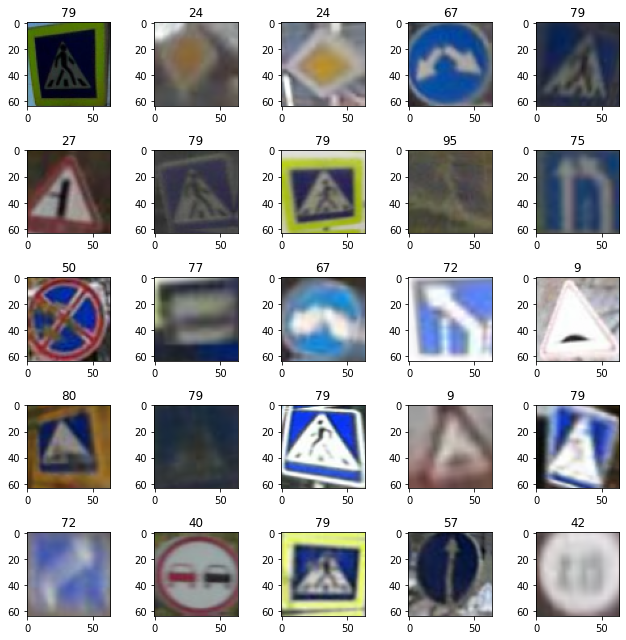

In [4]:
data.show_batch(5, figsize=(9, 9), hide_axis=False)

In [5]:
learn = cnn_learner(data, models.squeezenet1_1, metrics=[accuracy]).to_fp16()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


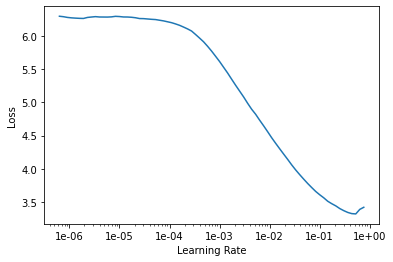

In [6]:
learn.lr_find()
learn.recorder.plot()

In [8]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.900052,0.925293,0.755463,01:43
1,0.695380,0.792190,0.775311,00:26
2,0.558052,0.741661,0.791058,00:21
3,0.476588,0.685169,0.800393,00:21
4,0.425844,0.645964,0.814569,00:21


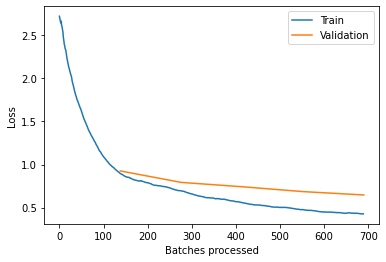

In [9]:
learn.recorder.plot_losses()

In [10]:
learn.save('m64x64s1v1')

In [11]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.466786,0.724382,0.799389,00:22
1,0.531825,0.734835,0.792323,00:22
2,0.489507,0.672200,0.804667,00:22
3,0.423393,0.641588,0.815049,00:22
4,0.385935,0.627470,0.820894,00:22


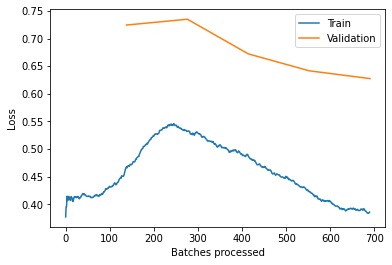

In [12]:
learn.recorder.plot_losses()

In [13]:
learn.save('m64x64s1v2')

In [17]:
learn.load('m64x64s1v2')
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


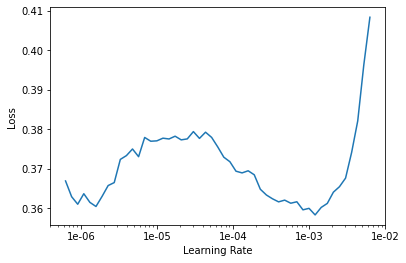

In [14]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(7, slice(3e-5, 4e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.318894,0.509061,0.852475,00:23
1,0.254398,0.446216,0.869487,00:23
2,0.213387,0.405506,0.877121,00:22
3,0.184459,0.359353,0.890120,00:22
4,0.164324,0.339136,0.896227,00:22
5,0.146243,0.327137,0.900065,00:22
6,0.141736,0.326853,0.899629,00:22


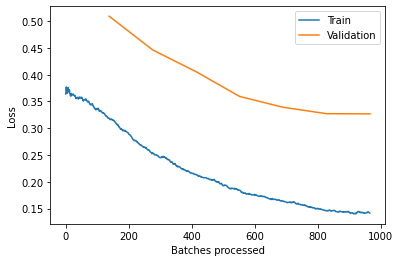

In [19]:
learn.recorder.plot_losses()

In [20]:
learn.save('m64x64s2v1')

In [26]:
learn.load('m64x64s2v1');

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


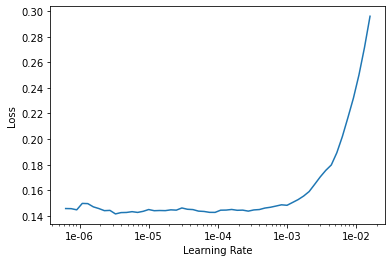

In [21]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(7, slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.144054,0.333882,0.897186,00:24
1,0.148301,0.350470,0.895529,00:23
2,0.142872,0.320496,0.898844,00:22
3,0.130900,0.294737,0.906478,00:22
4,0.119118,0.291497,0.909444,00:22
5,0.110375,0.281200,0.911276,00:22
6,0.105388,0.280497,0.911843,00:22


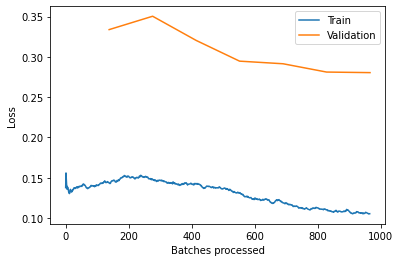

In [28]:
learn.recorder.plot_losses()

In [29]:
learn.save('m64x64s2v2')

In [30]:
learn.save('m64x64top')

In [199]:
top_models_dir = Path('models')
top_models_dir.mkdir(parents=True, exist_ok=True)
for p in (ds_root / 'models').glob('m*top.pth'):
    shutil.copy(p, top_models_dir)

In [200]:
learn.export()

In [31]:
interpret = ClassificationInterpretation.from_learner(learn)

In [37]:
confusion_matrix = interpret.confusion_matrix()

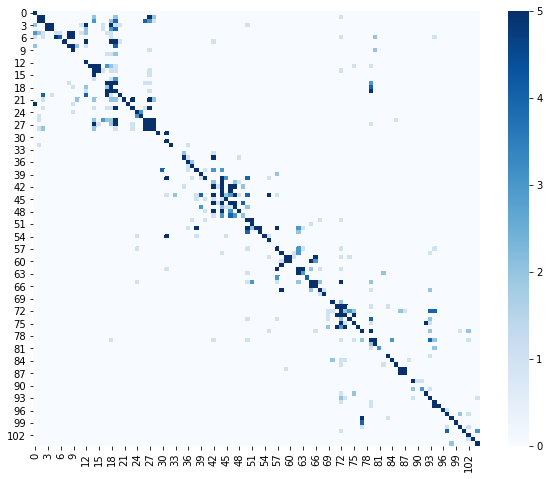

In [64]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, vmin=0, vmax=5, cmap='Blues');

In [153]:
tp_vec = np.diag(confusion_matrix)
tcp_vec = np.sum(confusion_matrix, axis=0)
pcp_vec = np.sum(confusion_matrix, axis=1)
mmask = (tcp_vec != 0) & (pcp_vec != 0)
tp_vec = tp_vec[mmask]
tcp_vec = tcp_vec[mmask]
pcp_vec = pcp_vec[mmask]

precision_vec = tp_vec / pcp_vec
recall_vec = tp_vec / tcp_vec
eps_vec = np.ones_like(precision_vec) * 1e-8
f1_vec = 2 * precision_vec * recall_vec / (precision_vec + recall_vec + eps_vec)

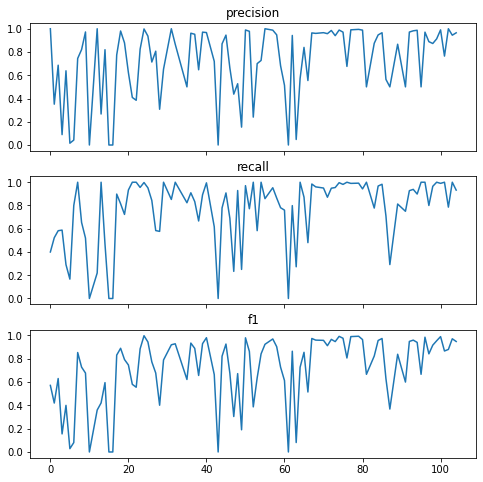

In [156]:
_, ax = plt.subplots(nrows=3, sharex=True, figsize=(8, 8))
plt.subplots_adjust(hspace=0.2)
classes = np.arange(confusion_matrix.shape[0])
x_vec = classes[mmask]
sns.lineplot(x_vec, precision_vec, ax=ax[0]).set_title('precision')
sns.lineplot(x_vec, recall_vec, ax=ax[1]).set_title('recall')
sns.lineplot(x_vec, f1_vec, ax=ax[2]).set_title('f1');

In [158]:
bad_cfn_classes = x_vec[f1_vec < 0.5]
bad_cfn_classes, f'{len(bad_cfn_classes) / len(x_vec) * 100:.2f}%'

(array([ 1,  3,  4,  5,  6, 10, 12, 13, 15, 16, 28, 43, 47, 49, 52, 61, 63, 87]),
 '19.15%')

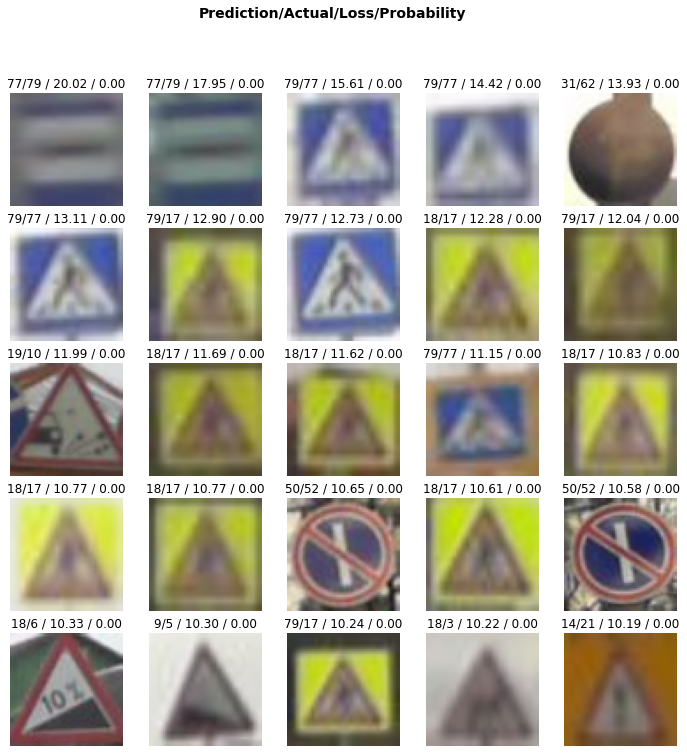

In [140]:
interpret.plot_top_losses(25)

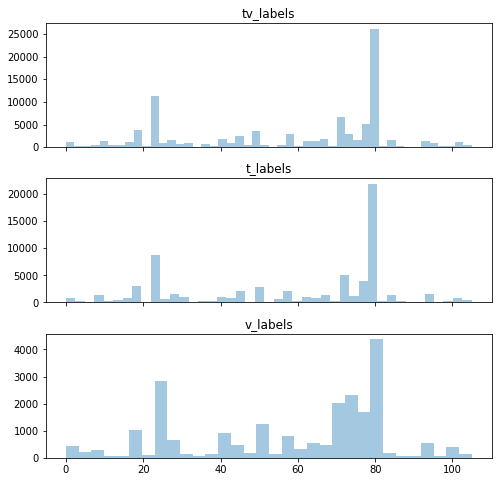

In [190]:
tv_labels = np.append(train_df['class_number'].to_numpy(), val_df['class_number'].to_numpy())
t_labels = train_df['class_number'].to_numpy()
v_labels = val_df['class_number'].to_numpy()

_, ax = plt.subplots(nrows=3, sharex=True, figsize=(8, 8))
plt.subplots_adjust(hspace=0.25)
sns.distplot(tv_labels, ax=ax[0], kde=False).set_title('tv_labels')
sns.distplot(t_labels, ax=ax[1], kde=False).set_title('t_labels')
sns.distplot(v_labels, ax=ax[2], kde=False).set_title('v_labels');

In [193]:
tv_labels_unique, tv_labels_counts = np.unique(tv_labels, return_counts=True)
tv_labels_threshold = 100
lt_10_images_classes = tv_labels_unique[tv_labels_counts < tv_labels_threshold]
ge_10_images_classes = tv_labels_unique[tv_labels_counts >= tv_labels_threshold]
len(lt_10_images_classes), len(ge_10_images_classes)

(33, 73)